In [12]:
from qutip import qeye, sigmax, sigmay, sigmaz, tensor, basis, mesolve,rand_ket, entropy_vn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [26]:
def generate_operators(N):
    si = qeye(2)
    sx = sigmax()
    sy = sigmay()
    sz = sigmaz()
    p = (si - sz) / 2.0

    sx_list = []
    sy_list = []
    sz_list = []
    p_list = []

    for n in range(N):
        op_list = [si] * N

        op_list[n] = sx
        sx_list.append(tensor(op_list))

        op_list[n] = sy
        sy_list.append(tensor(op_list))

        op_list[n] = sz
        sz_list.append(tensor(op_list))

        op_list[n] = p
        p_list.append(tensor(op_list))

    return sx_list, sy_list, sz_list, p_list

def create_PXP_Hamiltonian(N, W, Omega, Bound):
    sx_list, sy_list, sz_list, p_list = generate_operators(N)

    H = 0
    for n in range(N - 2):
        H += Omega *p_list[n] * sx_list[n + 1] * p_list[n + 2]

    # Boundary conditions
    if Bound == 'pbc' or Bound == 'PBC':
        H += Omega * (p_list[N - 2] * sx_list[N - 1] * p_list[0] + p_list[N - 1] * sx_list[0] * p_list[1])  # PBC

    if Bound == 'obc' or Bound == 'OBC':
        H += Omega * (sx_list[0] * p_list[1] + p_list[N - 2] * sx_list[N - 1])  # OBC

    # Random uniform distribution of perturbation strength values
    hw = np.random.uniform(-W / 2, W / 2, (3 * N))
    m = 0
    for n in range(N):
        H += hw[m] * sx_list[n] + hw[m + 1] * sy_list[n] + hw[m + 2] * sz_list[n]  # Perturbing all directions
        m += 3
    
    return H

def create_Z_Hamiltonian(N, delta_max, data_point):
    _, sz_list, _ = generate_operators(N)
    H_Z = 0
    for i, sz in enumerate(sz_list):
        H_Z += delta_max * (2 * data_point[i] - 1) * sz
    return H_Z


def initial_Z2_state(N):
    return tensor([basis(2, i % 2) for i in range(N)])

In [5]:
# Function to create unitary evolution operators using mesolve
def create_unitary_mesolve(H, T, steps):
    tlist = np.linspace(0, T, steps)
    result = mesolve(H, qeye(H.dims[0][0]), tlist, [], [])
    return result.states[-1]

# Function to calculate the kernel between two data points with time evolution using mesolve
def kernel_function_mesolve(x, y, N, Omega_max, delta_max, T, steps):
    # Create the Hamiltonians
    H_PXP = create_PXP_Hamiltonian(N, Omega_max)
    
    # Modulate H_Z for x and y
    H_Z_x = create_Z_Hamiltonian(N, delta_max, x)
    H_Z_y = create_Z_Hamiltonian(N, delta_max, y)
    
    # Total Hamiltonians
    H_x = H_PXP + H_Z_x
    H_y = H_PXP + H_Z_y
    
    # Initial state
    Z2_state = initial_Z2_state(N)
    
    # Evolve the state using mesolve to get the unitary matrix
    U_y = create_unitary_mesolve(H_y, T, steps)
    U_x_dagger = create_unitary_mesolve(H_x, T, steps).dag()
    
    # Calculate the inner product
    final_state = U_x_dagger * (U_y * Z2_state)
    fidelity = np.abs(Z2_state.overlap(final_state))**2
    return fidelity

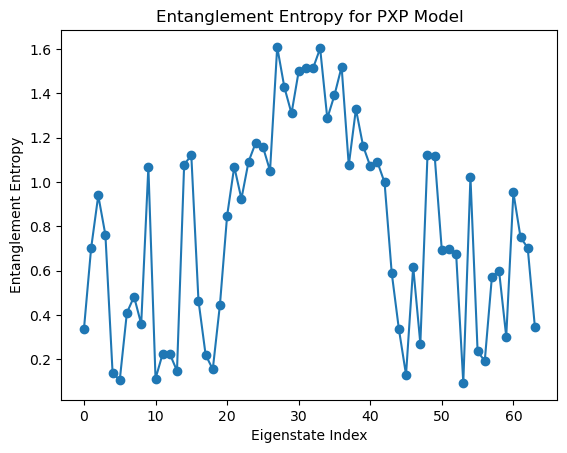

In [31]:
def compute_entanglement_entropy(N, W, Bound):
    H = create_PXP_Hamiltonian(N, W, Omega, Bound)
    eigenvalues, eigenstates = H.eigenstates()
    entropies = [entropy_vn(state.ptrace(list(range(N//2)))) for state in eigenstates]
    return entropies

# Example parameters
N = 8 # Small chain size
Omega = 1.0
W = 0.1
Bound = 'PBC'

entropies = compute_entanglement_entropy(N, W, Bound)

plt.plot(entropies, marker='o')
plt.xlabel('Eigenstate Index')
plt.ylabel('Entanglement Entropy')
plt.title('Entanglement Entropy for PXP Model')
plt.show()

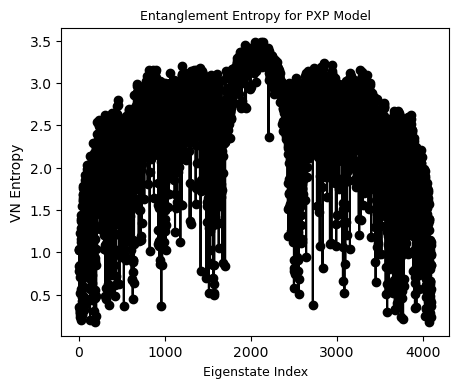

In [29]:
plt.figure(figsize=(5, 4))
plt.plot(entropies, marker='o', label = 'PXP + Hvec, L = 12, W = 0.1', color = 'black')
plt.xlabel('Eigenstate Index',fontsize = 9)
plt.ylabel('VN Entropy')
plt.title('Entanglement Entropy for PXP Model',fontsize = 9)
plt.show()

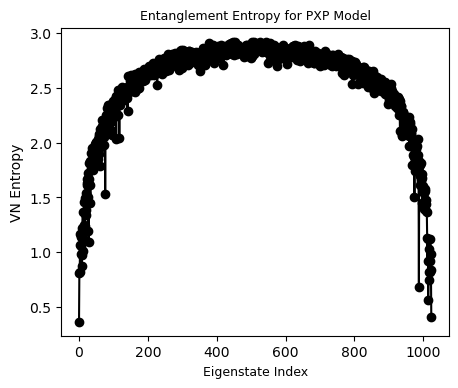

In [23]:
plt.figure(figsize=(5, 4))
plt.plot(entropies, marker='o', label = 'PXP + Hvec, L = 10, W = 0.5', color = 'black')
plt.xlabel('Eigenstate Index',fontsize = 9)
plt.ylabel('VN Entropy')
plt.title('Entanglement Entropy for PXP Model',fontsize = 9)
plt.show()

In [53]:
def compute_entanglement_entropy(N, W, Omega, Bound):
    H = create_PXP_Hamiltonian(N, W, Omega, Bound)
    eigenvalues, eigenstates = H.eigenstates()
    entropies = [entropy_vn(state.ptrace(list(range(N//2)))) for state in eigenstates]
    return entropies

def ensemble_average_entanglement_entropy(N, W, Omega, Bound, num_realizations):
    all_entropies = np.zeros((num_realizations, 2**N))
    
    for i in tqdm(range(num_realizations)):
        entropies = compute_entanglement_entropy(N, W, Omega, Bound)
        all_entropies[i, :] = entropies
    
    average_entropies = np.mean(all_entropies, axis=0)
    return average_entropies

# Example parameters
N = 10  # Small chain size
Omega = 1.0
W = 0.7
Bound = 'PBC'
num_realizations = 100

average_entropies10 = ensemble_average_entanglement_entropy(N, W, Omega, Bound, num_realizations)

  0%|          | 0/100 [00:00<?, ?it/s]

In [44]:
np.savetxt(u"C:\\Users\\msaha\\Downloads\\ensAvgVNE-PXPvecHz-N8ens100Om1W01PBC.dat",average_entropies1)
np.savetxt(u"C:\\Users\\msaha\\Downloads\\ensAvgVNE-PXPvecHz-N8ens100Om1W03PBC.dat",average_entropies2)
np.savetxt(u"C:\\Users\\msaha\\Downloads\\ensAvgVNE-PXPvecHz-N8ens100Om1W05PBC.dat",average_entropies3)
np.savetxt(u"C:\\Users\\msaha\\Downloads\\ensAvgVNE-PXPvecHz-N8ens100Om1W07PBC.dat",average_entropies4)
np.savetxt(u"C:\\Users\\msaha\\Downloads\\ensAvgVNE-PXPvecHz-N8ens100Om1W09PBC.dat",average_entropies5)

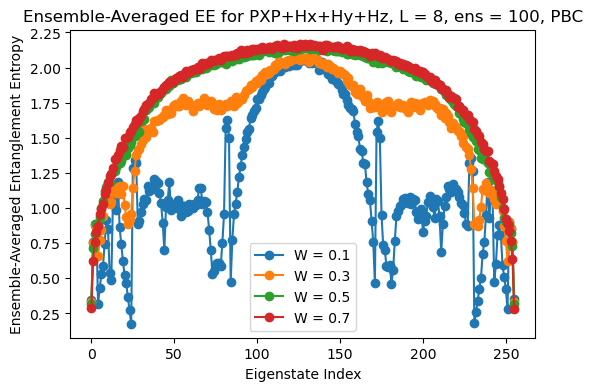

In [55]:
plt.figure(figsize=(6, 4))
plt.plot(average_entropies1, marker='o', label = 'W = 0.1')
plt.plot(average_entropies2, marker='o', label = 'W = 0.3')
plt.plot(average_entropies3, marker='o', label = 'W = 0.5')
plt.plot(average_entropies4, marker='o', label = 'W = 0.7')
#plt.plot(average_entropies5, marker='o', label = 'W = 0.9')
plt.xlabel('Eigenstate Index')
plt.ylabel('$S_{VN}$')
plt.title('Ensemble-Averaged EE for PXP+Hx+Hy+Hz, L = 8, ens = 100, PBC')
plt.legend()
plt.show()

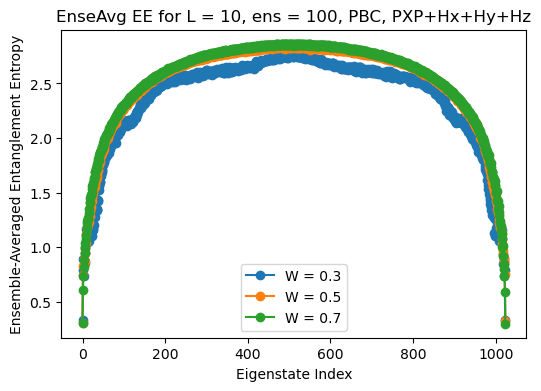

In [54]:
plt.figure(figsize=(6, 4))
# plt.plot(average_entropies7, marker='o', label = 'W = 0.0')
# plt.plot(average_entropies6, marker='o', label = 'W = 0.1')
plt.plot(average_entropies8, marker='o', label = 'W = 0.3')
plt.plot(average_entropies9, marker='o', label = 'W = 0.5')
plt.plot(average_entropies10, marker='o', label = 'W = 0.7')
plt.xlabel('Eigenstate Index')
plt.ylabel('Ensemble-Averaged Entanglement Entropy')
plt.title('EnseAvg EE for L = 10, ens = 100, PBC, PXP+Hx+Hy+Hz')
plt.legend()
plt.show()